In [1]:
#Reference:
#dataset reference link :https://www.tensorflow.org/datasets/catalog/cycle_gan#cycle_ganiphone2dslr_flower
#CycleGAN code:In this part, I used a lot of the model code from this link:https://www.tensorflow.org/tutorials/generative/cyclegan?hl=zh-cn

In [2]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /private/var/folders/ns/6zjqs7250rb8bzsvg7yt4bv00000gn/T/pip-req-build-pzple2hy
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /private/var/folders/ns/6zjqs7250rb8bzsvg7yt4bv00000gn/T/pip-req-build-pzple2hy
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install git+https://github.com/tensorflow/examples/tree/master/tensorflow_examples

In [4]:
!pip install tensorflow


In [5]:
import tensorflow as tf

2024-03-13 22:24:10.620829: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
!pip install tensorflow-datasets


In [7]:
from tensorflow_examples.models.pix2pix import pix2pix


In [8]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

In [9]:
#reference: from this link:https://www.tensorflow.org/tutorials/generative/cyclegan?hl=zh-cn
#data reference: this ukiyoe2photo from:https://www.tensorflow.org/datasets/catalog/cycle_gan#cycle_ganiphone2dslr_flower
dataset, metadata = tfds.load('cycle_gan/ukiyoe2photo',
                              with_info=True, as_supervised=True)

train_ukiyoe, train_photo = dataset['trainA'], dataset['trainB']
test_ukiyoe, test_photo = dataset['testA'], dataset['testB']

In [10]:
#reference: https://www.tensorflow.org/tutorials/generative/cyclegan?hl=zh-cn
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [11]:
#reference: https://www.tensorflow.org/tutorials/generative/cyclegan?hl=zh-cn
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [12]:
#reference: https://www.tensorflow.org/tutorials/generative/cyclegan?hl=zh-cn
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [13]:
#reference: https://www.tensorflow.org/tutorials/generative/cyclegan?hl=zh-cn
def random_jitter(image):
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  image = random_crop(image)

  image = tf.image.random_flip_left_right(image)

  return image

In [14]:
#reference: https://www.tensorflow.org/tutorials/generative/cyclegan?hl=zh-cn
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [15]:
#reference: https://www.tensorflow.org/tutorials/generative/cyclegan?hl=zh-cn
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [16]:
#reference: https://www.tensorflow.org/tutorials/generative/cyclegan?hl=zh-cn
train_ukiyoe = train_ukiyoe.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_photo = train_photo.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_ukiyoe = test_ukiyoe.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_photo = test_photo.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [17]:
#reference: https://www.tensorflow.org/tutorials/generative/cyclegan?hl=zh-cn
sample_ukiyoe = next(iter(train_ukiyoe))
sample_photo = next(iter(train_photo))

2024-03-13 22:24:27.784246: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


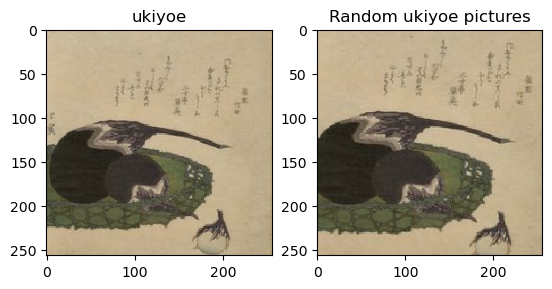

In [18]:
#reference: https://www.tensorflow.org/tutorials/generative/cyclegan?hl=zh-cn
plt.subplot(121)
plt.title('ukiyoe')
plt.imshow(sample_ukiyoe[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Random ukiyoe pictures')
plt.imshow(random_jitter(sample_ukiyoe[0]) * 0.5 + 0.5)

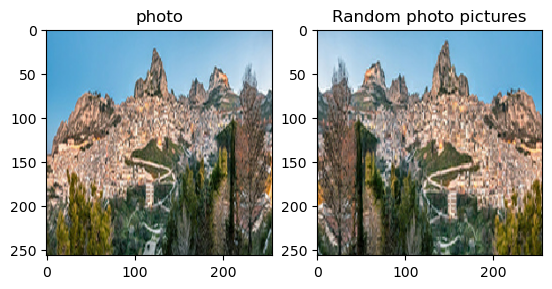

In [19]:
#reference: https://www.tensorflow.org/tutorials/generative/cyclegan?hl=zh-cn
plt.subplot(121)
plt.title('photo')
plt.imshow(sample_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Random photo pictures')
plt.imshow(random_jitter(sample_photo[0]) * 0.5 + 0.5)

In [20]:
#reference: https://www.tensorflow.org/tutorials/generative/cyclegan?hl=zh-cn
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

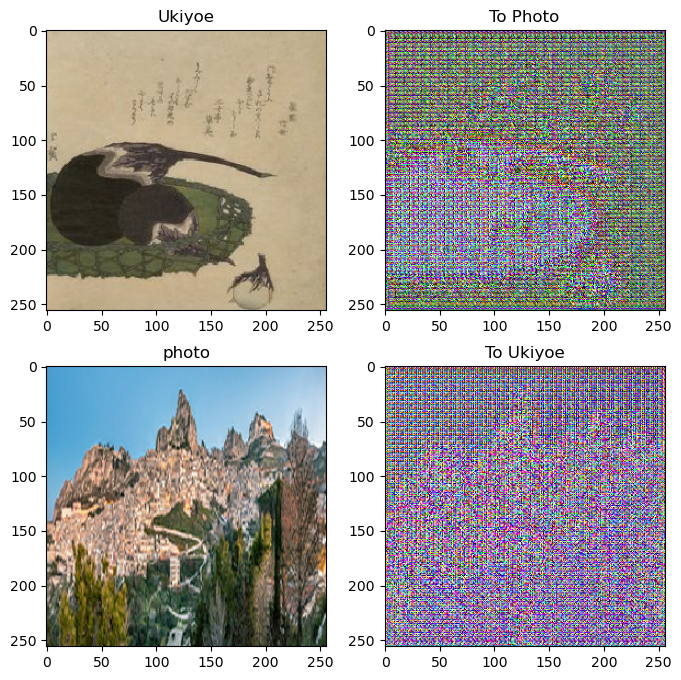

In [21]:
#reference: https://www.tensorflow.org/tutorials/generative/cyclegan?hl=zh-cn
to_photo = generator_g(sample_ukiyoe)
to_ukiyoe = generator_f(sample_photo)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_ukiyoe, to_photo, sample_photo, to_ukiyoe]
title = ['Ukiyoe', 'To Photo', 'photo', 'To Ukiyoe']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

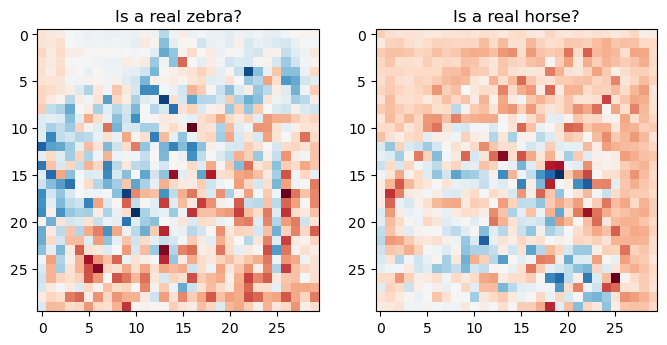

In [22]:
#reference: https://www.tensorflow.org/tutorials/generative/cyclegan?hl=zh-cn
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_y(sample_photo)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_x(sample_ukiyoe)[0, ..., -1], cmap='RdBu_r')

plt.show()

In [23]:
#reference: https://www.tensorflow.org/tutorials/generative/cyclegan?hl=zh-cn
LAMBDA = 10

In [24]:
#reference: https://www.tensorflow.org/tutorials/generative/cyclegan?hl=zh-cn
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [25]:
#reference: https://www.tensorflow.org/tutorials/generative/cyclegan?hl=zh-cn
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [26]:
#reference: https://www.tensorflow.org/tutorials/generative/cyclegan?hl=zh-cn
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [27]:
#reference: https://www.tensorflow.org/tutorials/generative/cyclegan?hl=zh-cn
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

In [28]:
#reference: https://www.tensorflow.org/tutorials/generative/cyclegan?hl=zh-cn
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [29]:
#reference: https://www.tensorflow.org/tutorials/generative/cyclegan?hl=zh-cn
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [30]:
#reference: https://www.tensorflow.org/tutorials/generative/cyclegan?hl=zh-cn
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [31]:
#reference: https://www.tensorflow.org/tutorials/generative/cyclegan?hl=zh-cn
EPOCHS = 10

In [32]:
#reference: https://www.tensorflow.org/tutorials/generative/cyclegan?hl=zh-cn
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [33]:
#reference: https://www.tensorflow.org/tutorials/generative/cyclegan?hl=zh-cn
@tf.function
def train_step(real_x, real_y):
  
  with tf.GradientTape(persistent=True) as tape:
   
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    

    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  

  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  

  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

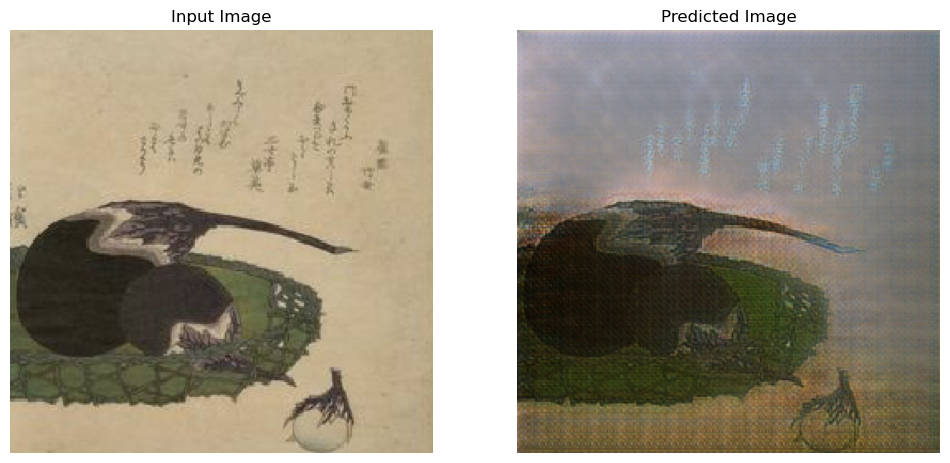

Saving checkpoint for epoch 10 at ./checkpoints/train/ckpt-4
Time taken for epoch 10 is 3812.2537438869476 sec



In [34]:
#reference: https://www.tensorflow.org/tutorials/generative/cyclegan?hl=zh-cn
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_ukiyoe, train_photo)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  
  generate_images(generator_g, sample_ukiyoe)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

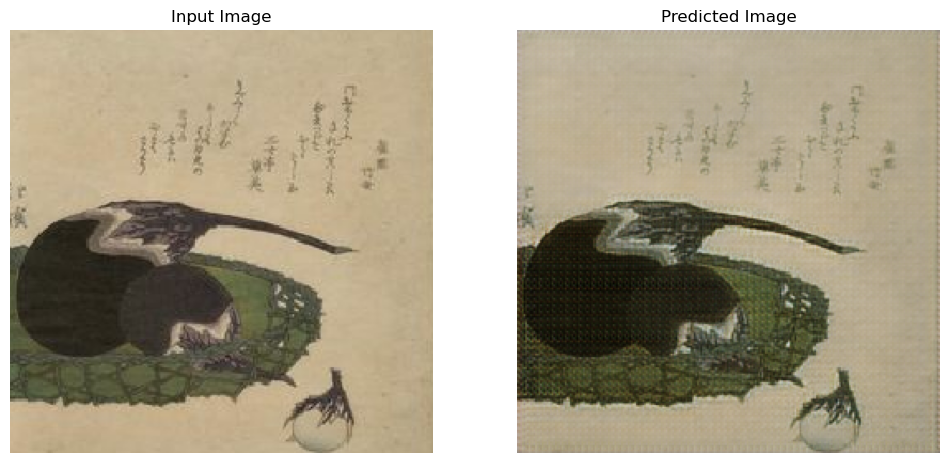

Time taken for epoch 9 is 2011.299559354782 sec

.........................................................

In [ ]:
#reference: https://www.tensorflow.org/tutorials/generative/cyclegan?hl=zh-cn
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_ukiyoe, train_photo)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  
  generate_images(generator_g, sample_ukiyoe)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

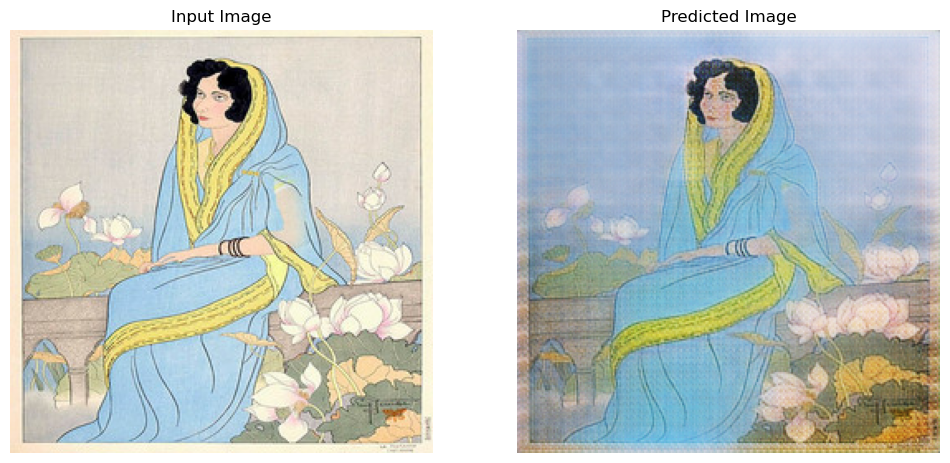

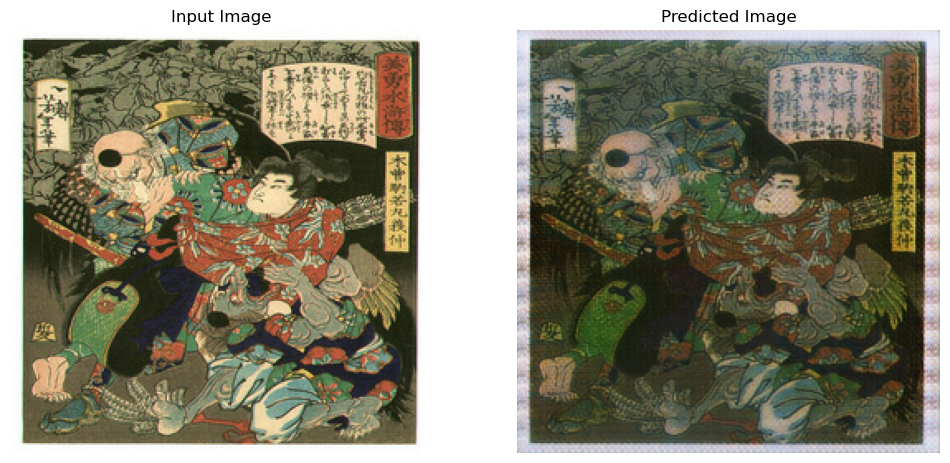

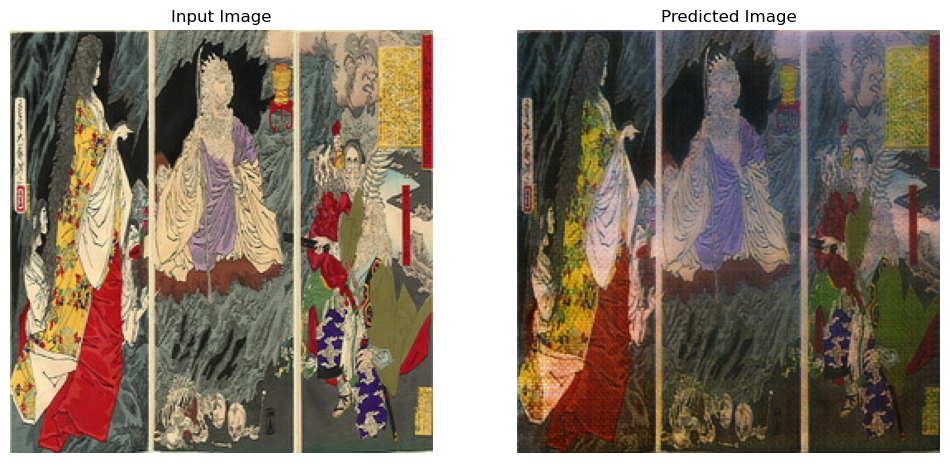

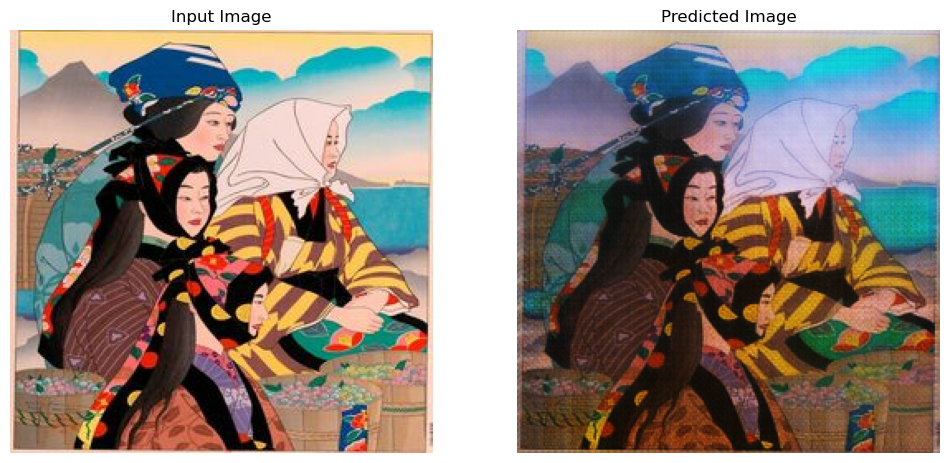

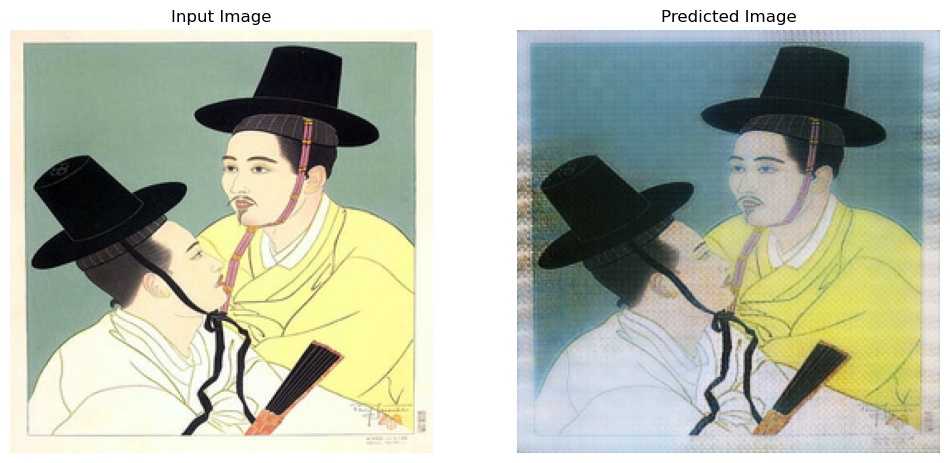

In [35]:
#reference: https://www.tensorflow.org/tutorials/generative/cyclegan?hl=zh-cn
# Run the trained model on the test dataset
for inp in test_ukiyoe.take(5):
  generate_images(generator_g, inp)